In [1]:
from tensorflow.keras.preprocessing import image
import numpy as np
import sys
import os

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, GRU
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import TimeDistributed,Bidirectional,GlobalAveragePooling2D
from tensorflow.keras.layers import LSTM,GRU,SimpleRNN,BatchNormalization
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as sp
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

2024-05-02 13:25:31.693036: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 13:25:31.697653: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 13:25:31.766873: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 13:25:31.768714: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf

import numpy as np
import os
from tensorflow import keras
#import keras
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


In [3]:
data_path = "/home/muhlabws4/Masaüstü/tkd_data/orj"

In [4]:
class_folders = os.listdir(data_path)

In [5]:
images = []
labels = []

In [6]:
for i , class_name in enumerate(class_folders):
    class_folder_path = os.path.join(data_path, class_name)
    class_images = os.listdir(class_folder_path)
    
    for img_name in class_images:
        img_path = os.path.join(class_folder_path, img_name)
        img = load_img(img_path, target_size=(180,320))
        img_array = img_to_array(img) /255.0
        images.append(img_array)
        labels.append(class_name)

In [7]:
X = np.array(images)
y = np.array(labels)

In [8]:
label_encoder = LabelEncoder()
y_encoder = label_encoder.fit_transform(y)

In [9]:
X_shuf, y_shuf = X, y_encoder

In [10]:
train_images, test_images, train_labels, test_labels = train_test_split(X_shuf, y_shuf, test_size=0.2, random_state=42)

In [11]:
print(X.shape)
print(y.shape)
print(y_encoder.shape)

(407, 180, 320, 3)
(407,)
(407,)


In [12]:
#class_names = ['head_sb','head_sesor', 'other','punch','rotation']
class_names = ['head', 'other','punch']

In [13]:
img_height=180
img_width=320
output=3

In [14]:
checkpoint_path = "best_modelX.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

In [15]:
def pretrained_Xception():
    base_model = Xception(weights="imagenet", include_top=False, input_shape = (img_height,img_width,3))
    base_model.trainable = True ## Not trainable weights
    flatten_layer = Flatten()
    dense_layer_1 = Dense(256, activation='relu')
    #dense_layer_2 = Dense(20, activation='relu')
    prediction_layer = Dense(output, activation='softmax')
    
    model = Sequential([
      base_model,
      flatten_layer,
      dense_layer_1,
      #dense_layer_2,
      prediction_layer
      ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', #değiştirrr
        metrics=['accuracy'],
        )
    
    return model

In [16]:

def cross_validation(model, X, y, n_splits=5, epochs=5, batch_size=32):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    #model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #result = []
    for train_inx, val_inx in kfold.split(X):
        X_train, X_val = X[train_inx], X[val_inx]
        y_train, y_val = y[train_inx], y[val_inx]
        
        
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        a = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, class_weight={0:7,1:17,2:22},callbacks=[checkpoint])
        #model.fit(X_train, y_train, epochs=epochs)
        #result.append(a.history['val_accuracy'])
        
    #return result

In [17]:
def gosterTrain(index):
    plt.figure(figsize=(15,2))
    plt.imshow(train_images[index])
    plt.title(class_names[train_labels[index]])

In [18]:
def gosterTest(index):
    plt.figure(figsize=(15,2))
    plt.imshow(test_images[index])
    plt.title(class_names[test_labels[index]])

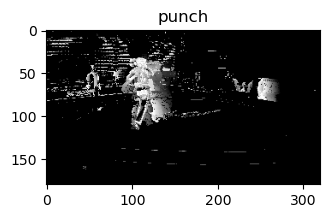

In [19]:
gosterTrain(10)

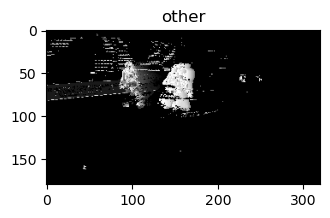

In [20]:
gosterTest(7)

In [21]:
modelX = pretrained_Xception()
result = cross_validation(modelX, train_images, train_labels, n_splits=3, epochs=8, batch_size=32)

2024-05-02 13:12:34.318080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 13:12:34.321055: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/8
7/7 - 19s - loss: 42.9177 - accuracy: 0.5139 - 19s/epoch - 3s/step
Epoch 2/8
7/7 - 13s - loss: 19.4899 - accuracy: 0.5833 - 13s/epoch - 2s/step
Epoch 3/8
7/7 - 13s - loss: 19.0485 - accuracy: 0.5833 - 13s/epoch - 2s/step
Epoch 4/8
7/7 - 13s - loss: 18.6085 - accuracy: 0.5833 - 13s/epoch - 2s/step
Epoch 5/8
7/7 - 13s - loss: 18.1823 - accuracy: 0.5833 - 13s/epoch - 2s/step
Epoch 6/8
7/7 - 13s - loss: 17.7720 - accuracy: 0.5833 - 13s/epoch - 2s/step
Epoch 7/8
7/7 - 14s - loss: 17.3688 - accuracy: 0.5833 - 14s/epoch - 2s/step
Epoch 8/8
7/7 - 15s - loss: 16.9954 - accuracy: 0.5833 - 15s/epoch - 2s/step
Epoch 1/8
7/7 - 22s - loss: 16.8770 - accuracy: 0.5392 - 22s/epoch - 3s/step
Epoch 2/8
7/7 - 15s - loss: 16.3735 - accuracy: 0.5392 - 15s/epoch - 2s/step
Epoch 3/8
7/7 - 13s - loss: 15.9762 - accuracy: 0.5392 - 13s/epoch - 2s/step
Epoch 4/8
7/7 - 13s - loss: 15.5953 - accuracy: 0.5392 - 13s/epoch - 2s/step
Epoch 5/8
7/7 - 13s - loss: 15.2946 - accuracy: 0.5392 - 13s/epoch - 2s/step

In [28]:
modelX.evaluate(test_images, test_labels)

3/3 [==============================] - 1s 340ms/step - loss: 1.1542 - accuracy: 0.5244


[1.1541593074798584, 0.5243902206420898]

In [23]:
tahminlerX = modelX.predict(test_images)

3/3 [==============================] - 1s 332ms/step


In [24]:
modelX.save(checkpoint_path)

/home/muhlabws4/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
y_pred_classes = np.argmax(tahminlerX,axis=1)

In [26]:
tahminlerX[:7]

array([[0.07038386, 0.25754535, 0.67207086],
       [0.07038386, 0.25754535, 0.67207086],
       [0.07038386, 0.25754535, 0.67207086],
       [0.07038386, 0.25754535, 0.67207086],
       [0.07038386, 0.25754535, 0.67207086],
       [0.07038386, 0.25754535, 0.67207086],
       [0.07038386, 0.25754535, 0.67207086]], dtype=float32)

In [27]:
np.argmax(tahminlerX[9])

2

In [43]:
test_labels

array([0, 2, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 1,
       2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 1, 2, 1, 1, 1, 2, 2,
       2, 1, 0, 1, 2, 2, 2, 0, 2, 0, 1, 1, 0, 0, 0, 2, 0, 2, 0, 2, 1, 2,
       1, 2, 0, 2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 1, 1, 1])

In [44]:
y_pred_classes

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 1, 0, 1, 1, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 1])

In [45]:
print(classification_report(test_labels, y_pred_classes))

              precision    recall  f1-score   support

           0       0.86      0.32      0.46        19
           1       0.78      0.35      0.48        20
           2       0.62      0.95      0.75        43

    accuracy                           0.66        82
   macro avg       0.75      0.54      0.57        82
weighted avg       0.71      0.66      0.62        82



In [46]:
conf_matrix = confusion_matrix(test_labels, y_pred_classes)

In [47]:
print(conf_matrix)

[[ 6  1 12]
 [ 0  7 13]
 [ 1  1 41]]


In [48]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)

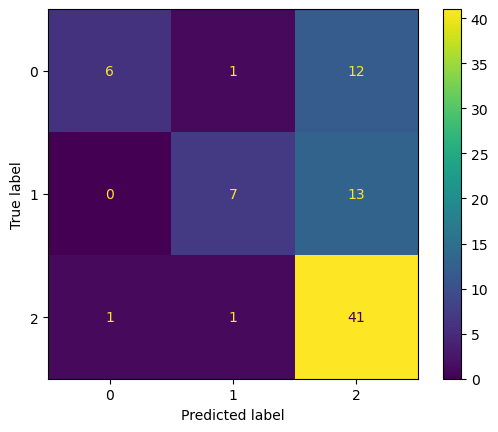

In [49]:
cm_display.plot()
plt.show() 